<a href="https://colab.research.google.com/github/AaronScherf/gxe-gee-lmm/blob/master/6_LMM_replication_gee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Grain Yields with a Pedigree-Based Reaction Norm GxE Model using the BGLR Package in R

From A Pedigree-Based Reaction Norm Model for Prediction of Cotton Yield in Multienvironment Trials

https://dl.sciencesocieties.org/publications/cs/abstracts/55/3/1143?access=0&view=pdf

## Install Necessary Packages and Mount Drive

In [0]:
# To host on a local runtime:
# Run the following from the command line or miniconda shell on your local machine:

# pip install jupyter_http_over_ws
# jupyter serverextension enable --py jupyter_http_over_ws

# conda create -n gxe_gee python=3.7 ipykernel jupyter anaconda
# conda activate gxe_gee
# ipython kernel install --name gxe_gee --user

# jupyter notebook \ --NotebookApp.allow_origin='https://colab.research.google.com' \ --port=8888 \ --NotebookApp.port_retries=0
# jupyter notebook  --NotebookApp.allow_origin='https://colab.research.google.com'  --port=8888  --NotebookApp.port_retries=0


In [0]:
# Installing rpy2 package through Python to run R code

#!pip install rpy2

# If pip install doesn't work, try:

# !conda install -c r rpy2

# If the conda install line doesn't work, or if you have issues on your locally hosted runtime, try the following:
# https://anaconda.zendesk.com/hc/en-us/articles/360023857134-Setting-up-rpy2-on-Windows


^C


In [1]:
!pip install tzlocal
!pip install simplegeneric

In [0]:
# import necessary libraries in Python
import pandas as pd
import numpy as np
import os

In [2]:
# activate R magic
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [3]:
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# import R's "base" package
base = importr('base')

# import rpy2's package module
import rpy2.robjects.packages as rpackages

# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

<rpy2.rinterface.NULLType object at 0x7ff04e5ed848> [RTYPES.NILSXP]

In [0]:
# Import the pandas2ri functions and activate
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [0]:
%%capture
%%R # Install other R Packages
# May result in RunTimeWarnings, these can be ignored
install.packages('dplyr')
install.packages('tidyverse')
install.packages('caret')
install.packages('BGLR')

In [5]:
%%R 
require("dplyr")
require('BGLR')
require('tidyverse')
require('caret')

R[write to console]: Loading required package: dplyr

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: Loading required package: BGLR

R[write to console]: Loading required package: tidyverse

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ stringr 1.4.0
✔ tidyr   1.0.2     ✔ forcats 0.5.0
✔ readr   1.3.1     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: caret



In [6]:
# Mount the Colab notebook in Google Drive
# Only if running from a hosted runtime in Colab, ignore if running locally

from google.colab import drive # import drive from google colab

drive.mount("/content/drive")  # mount the google drive at /content/drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
# Search for the root directory of the project in Drive and save as a path string

parent_dir_name = 'GxE with GEE'

for dirpath, subdirs, files in os.walk('/content'):
  if parent_dir_name in subdirs:
    parent_path = dirpath + "/" + parent_dir_name

parent_path

'/content/drive/My Drive/Research/GxE with GEE'

In [8]:
# Set Data Path
## Change the destination to your Drive directory containing the folder 'raw_data.zip'
data_path_end = '/Colab Workspace/Data'
data_path = parent_path + data_path_end
os.chdir(data_path)
os.getcwd()

'/content/drive/My Drive/Research/GxE with GEE/Colab Workspace/Data'

In [0]:
# Locally hosted version, just set the destination manually

# data_path = 'C:/Users/theaa/Downloads'
# os.chdir('C:/Users/theaa/Downloads')
# os.getcwd()

'C:\\Users\\theaa\\Downloads'

In [0]:
%%R -i data_path
# Import the parent_path object from Python and use to set the R working directory
 setwd(data_path)

In [10]:
%%R
getwd()

[1] "/content/drive/My Drive/Research/GxE with GEE/Colab Workspace/Data"


## Methods Source Papers

From A Pedigree-Based Reaction Norm Model for Prediction of Cotton Yield in Multienvironment Trials

https://dl.sciencesocieties.org/publications/cs/abstracts/55/3/1143?access=0&view=pdf

### Description of Data Objects

* `Y`: data frame containing the elements described below;

  * `Y$grain_yield` (n×1), a numeric vector with centered and standardized yield;

  * `Y$VAR`  (n×1), a factor giving the IDs for the varieties;

  * `Y$ENV` (n×1), a factor giving the IDs for the environments (year-location);

* `A`: a symmetric positive semi-definite matrix containing the pedigree or marker-based relationships (dimensions equal to number of lines by number of lines). We assume that the `rownames(A)=colnames(A)` gives the IDs of the lines;

* `W`: a matrix containing the environmental covariates (n×q).


## Import Data and Prep for Analysis

In [0]:
# Import pickle of target data and export as CSV
y_train_scaled = pd.read_pickle('y_train_scaled.pkl')
y_test_scaled = pd.read_pickle('y_test_scaled.pkl')
y_train_scaled.to_csv('y_train_scaled.csv')
y_test_scaled.to_csv('y_test_scaled.csv')

In [0]:
# Import pickle of CIMMYT environmental variables and export as CSV
X_train_scaled = pd.read_pickle('X_train_scaled.pkl')
X_test_scaled = pd.read_pickle('X_test_scaled.pkl')
X_train_scaled.to_csv('X_train_scaled.csv')
X_test_scaled.to_csv('X_test_scaled.csv')

In [0]:
# Import pickle of GEE environmental variables and export as CSV
X_train_gee_scaled = pd.read_pickle('X_train_gee_scaled.pkl')
X_test_gee_scaled = pd.read_pickle('X_test_gee_scaled.pkl')
X_train_gee_scaled.to_csv('X_train_gee_scaled.csv')
X_test_gee_scaled.to_csv('X_test_gee_scaled.csv')

In [0]:
# Import pickle of pedigree coefficient matrix and export as CSV
A = pd.read_pickle('A_matrix_unique.pkl')
A.to_csv('A_matrix_unique.csv')

In [0]:
%%R
# Import CSV files of target data
y_train <- read.csv('y_train_scaled.csv', row.names = 1)
y_test <- read.csv('y_test_scaled.csv', row.names = 1)

In [18]:
%%R
print(dim(y_train))
print(dim(y_test))

[1] 93146     1
[1] 23287     1


In [0]:
%%R
# Import CSV files of environmental data for CIMMYT and GEE
W_CIMMYT_train <- read.csv('X_train_scaled.csv', row.names = 1)
W_CIMMYT_test <- read.csv('X_test_scaled.csv', row.names = 1)
W_gee_train <- read.csv('X_train_gee_scaled.csv', row.names = 1)
W_gee_test <- read.csv('X_test_gee_scaled.csv', row.names = 1)

In [17]:
%%R
print(dim(W_CIMMYT_train))
print(dim(W_CIMMYT_test))
print(dim(W_gee_train))
print(dim(W_gee_test))

[1] 93146    58
[1] 23287    58
[1] 93146   260
[1] 23287   260


In [0]:
%%R
# Import pedigree matrix
A <- read.csv('A_matrix_unique.csv', row.names = 1)

In [22]:
%%R
dim(A)

[1] 3443 3443


In [19]:
%%R
# A matrix doesn't read in well as a CSV, need to repeat some processing steps
# Remove the X prefix from the column names
names(A) <- substring(names(A),2)
A <- A[order(rownames(A)),order(names(A))]
print(colnames(A)[1])
print(rownames(A)[1])

[1] "100507"
[1] "100507"


In [42]:
%%R
A[1:5,1:5]

        X100507  X100761  X1047493  X1050296  X1058137
100507      1.5 0.000000 0.0000000 0.0000000 0.0000000
100761      0.0 1.527344 0.0000000 0.0000000 0.0000000
1047493     0.0 0.000000 1.5905526 0.5575323 0.2434399
1050296     0.0 0.000000 0.5575323 1.6102377 0.2187396
1058137     0.0 0.000000 0.2434399 0.2187396 1.4766731


In [0]:
%%R
X_train_GID <- read.csv('X_train_GID.csv', row.names=1)
X_test_GID <- read.csv('X_test_GID.csv',row.names=1)

In [63]:
%%R
head(X_train_GID)

                            GID
36ESWYT_20027_560623_14 6934907
17ESWYT_65001_48579_21   143058
37ESWYT_22210_562707_52 7047479
2SAWYT_53002_20593_321    88598
21ESWYT_20409_122467_76  376718
21ESWYT_47503_91275_32  1301802


## Run Model on Sample of Data

Full dataset is too large, creates a 156Gb matrix and crashes the instance

In [21]:
%%R
# Set Sample Indices
train_random_sample <- sample(nrow(y_train), size = (nrow(y_train) * 0.15))
test_random_sample <- sample(nrow(y_test), size = (nrow(y_test) * 0.15))
train_random_sample[0:5]

[1]  9540 76646 34640 33686 15928


In [0]:
%%R
# Sample Target Data
y_train_sample <- as.data.frame(y_train[train_random_sample,], row.names = row.names(y_train)[train_random_sample])
colnames(y_train_sample) <- c('GRAIN_YIELD')
y_test_sample <- as.data.frame(y_test[test_random_sample,], row.names = row.names(y_test)[test_random_sample])
colnames(y_test_sample) <- c('GRAIN_YIELD')

# Sample CIMMYT Environmental Data
W_CIMMYT_train_sample <- W_CIMMYT_train[train_random_sample,]
W_CIMMYT_test_sample <- W_CIMMYT_test[test_random_sample,]

# Sample GEE Environmental Data
W_gee_train_sample <- W_gee_train[train_random_sample,]
W_gee_test_sample <- W_gee_test[test_random_sample,]

# Sample Unique GID List
X_train_GID_sample <- as.data.frame(X_train_GID[train_random_sample,], row.names = row.names(X_train_GID)[train_random_sample])
colnames(X_train_GID_sample) <- c('GID')
X_test_GID_sample <- as.data.frame(X_test_GID[test_random_sample,], row.names = row.names(X_test_GID)[test_random_sample])
colnames(X_test_GID_sample) <- c('GID')

In [23]:
%%R
# Combine Train and Test but keep index of separation
y_sample <- rbind(y_train_sample,y_test_sample)
W_CIMMYT_sample <- rbind(W_CIMMYT_train_sample, W_CIMMYT_test_sample)
W_gee_sample <- rbind(W_gee_train_sample, W_gee_test_sample)
X_GID_sample <- rbind(X_train_GID_sample, X_test_GID_sample)
print(length(y_sample[train_random_sample,]))
print(length(y_sample[test_random_sample,]))

[1] 13971
[1] 3493


In [28]:
%%R
head(X_GID_sample)

                             GID
11SAWYT_25201_158452_133 3574436
17ESWYT_22612_8626_465    447647
5HRWYT_21103_8779_136     455512
17SAWYT_51003_437242_88  5423700
5ESWYT_53002_8918_5        41800
4ESWYT_11101_7691_85       20424


In [24]:
%%R
set.seed(123)
training.samples <- y_sample$GRAIN_YIELD %>%
  createDataPartition(p = 0.8, list = FALSE)

y_train_na = y_sample$GRAIN_YIELD
y_train_na[-training.samples] = NA

R[write to console]: Error in createDataPartition(., p = 0.8, list = FALSE) : 
  could not find function "createDataPartition"
Calls: <Anonymous> ... eval -> _fseq -> freduce -> withVisible -> <Anonymous>

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
R[write to console]: 
 
R[write to console]:  there is no package called ‘BGLR’

R[write to console]: 2: 
R[write to console]: In library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE,  :
R[write to console]: 
 
R[write to console]:  there is no package called ‘caret’




Error in createDataPartition(., p = 0.8, list = FALSE) : 
  could not find function "createDataPartition"
Calls: <Anonymous> ... eval -> _fseq -> freduce -> withVisible -> <Anonymous>


## Model 1 : Main Variety Effects

In [25]:
%%R
# Fitting Model 1 (Main Environment-Line Effects)
# (EL)

# incidence matrix for main eff. of environments.
# ZE = model.matrix(~factor(Y$ENV)-1)     

# incidence matrix for main eff. of lines.
X_GID_sample$GID = factor(x=X_GID_sample$GID,levels=rownames(A),ordered=TRUE)
ZVAR = model.matrix(~X_GID_sample$GID-1)
print(dim(ZVAR))
print(length(y_train_na))

[1] 17464  3443


R[write to console]: Error in print(length(y_train_na)) : object 'y_train_na' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> print




Error in print(length(y_train_na)) : object 'y_train_na' not found
Calls: <Anonymous> -> <Anonymous> -> withVisible -> print


In [0]:
%%R
# Model Fitting

# ETA = list(ENV=list(X=ZE,model='BRR'),
#            VAR=list(X=ZVAR,model='BRR'))
	
ETA = list(VAR=list(X=ZVAR,model='BRR'))

fm1 = BGLR(y=y_train_na,ETA=ETA,saveAt='M1_',nIter=500,burnIn=200)

         R2     RMSE       MAE
1 0.1468556 0.956388 0.7575749


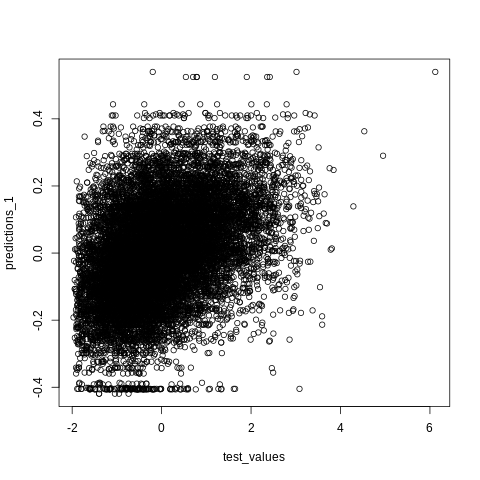

In [28]:
%%R
predictions_1 = fm1$yHat[-train_random_sample]
test_values = y_sample$GRAIN_YIELD[-train_random_sample]
R2 = R2(predictions_1, test_values)
RMSE = RMSE(predictions_1, test_values)
MAE = MAE(predictions_1, test_values)
model1_scores = data.frame(R2, RMSE, MAE)
print(model1_scores)
plot(test_values,predictions_1)

## Model 2: Main Pedigree Effects

In [0]:
%%R
# Alternative Model 2 with Eigendecomposition

L_star = eigen(A, symmetric =TRUE)
Gamma = L_star$vectors
Lambda = L_star$values 
Z_star = ZVAR%*%Gamma%*%(Lambda^0.5)



In [0]:
%%R
# Fitting Model 2 with Alternative Z_star (Main Environment-Pedigree Effects)
# (EA)

# ETA = list(ENV=list(X=ZE,model='BRR'),
#            PED=list(X=Z_star,model='BRR'))

ETA = list(PED=list(X=Z_star,model='BRR'))
	
fm2 = BGLR(y=y_train_na,ETA=ETA,saveAt='M2_',nIter=500,burnIn=100)

In [0]:
%%R
predictions_2 = fm2$yHat[-train_random_sample]
test_values = y_sample$GRAIN_YIELD[-train_random_sample]
R2 = R2(predictions_2, test_values)
RMSE = RMSE(predictions_2, test_values)
MAE = MAE(predictions_2, test_values)
model2_scores = data.frame(R2, RMSE, MAE)
print(model2_scores)
plot(test_values,predictions_2)

### Original Model 2 Code

In [0]:
%%R
# Fitting Model 2 (Main Environment-Pedigree Effects)
# (EA)

# A = A/mean(diag(A))
# L = t(chol(A))
# ZL = ZVAR%*%L

# ETA = list(ENV=list(X=ZE,model='BRR'),
#            PED=list(X=ZL,model='BRR'))
	
# fm2 = BGLR(y=y_train,ETA=ETA,saveAt='M2_',nIter=500,burnIn=200)


In [0]:
%%R
# predictions = fm2$yHat[-training.samples]
# test_values = Y$grain_yield[-training.samples]
# print(data.frame( R2 = R2(predictions, test_values),
#             RMSE = RMSE(predictions, test_values),
#             MAE = MAE(predictions, test_values)))

# plot(test_values,predictions)

## Model 3: Just Environment Main Effects

In [0]:
%%R
# Model 3 with just EC
ETA = list(EC=list(X=W_CIMMYT_sample_div,model='BRR'))

fm3_ec_CIMMYT = BGLR(y=y_train_na,ETA=ETA,saveAt='M3_',nIter=500,burnIn=200)


In [0]:
%%R
predictions_3_CIMMYT = fm3_ec_CIMMYT$yHat[-train_random_sample]
test_values = y_sample$GRAIN_YIELD[-train_random_sample]
R2 = R2(predictions_3_CIMMYT, test_values)
corr = cor(predictions_3_CIMMYT, test_values)
RMSE = RMSE(predictions_3_CIMMYT, test_values)
MAE = MAE(predictions_3_CIMMYT, test_values)
model3_CIMMYT_scores = data.frame(R2, RMSE, MAE)
print(model3_CIMMYT_scores)
plot(test_values,predictions_3_CIMMYT)

In [0]:
%%R
# Model 3 with just EC
ETA = list(EC=list(X=W_gee_sample_div,model='BRR'))

fm3_ec_gee = BGLR(y=y_train_na,ETA=ETA,saveAt='M3_',nIter=500,burnIn=200)


In [0]:
%%R
predictions_3_gee = fm3_ec_gee$yHat[-train_random_sample]
test_values = y_sample$GRAIN_YIELD[-train_random_sample]
R2 = R2(predictions_3_gee, test_values)
corr = cor(predictions_3_gee, test_values)
RMSE = RMSE(predictions_3_gee, test_values)
MAE = MAE(predictions_3_gee, test_values)
model3_CIMMYT_scores = data.frame(R2, RMSE, MAE)
print(model3_CIMMYT_scores)
plot(test_values,predictions_3_gee)

## Model 4: Main Pedigree and Environment Effects

In [0]:
%%R
# Fitting Model 3_CIMMYT (Main Environment-Pedigree-Environmental Covariate Effects)
# (EAW)

W_CIMMYT_sample_div = W_CIMMYT_sample/sqrt(ncol(W_CIMMYT_sample))


In [0]:
%%R
ETA = list(PED=list(X=Z_star,model='BRR'),
           EC=list(X=W_CIMMYT_sample_div,model='BRR'))

fm3_CIMMYT = BGLR(y=y_train_na,ETA=ETA,saveAt='M3_',nIter=500,burnIn=200)


         R2      RMSE       MAE
1 0.1285132 0.9333706 0.7374322


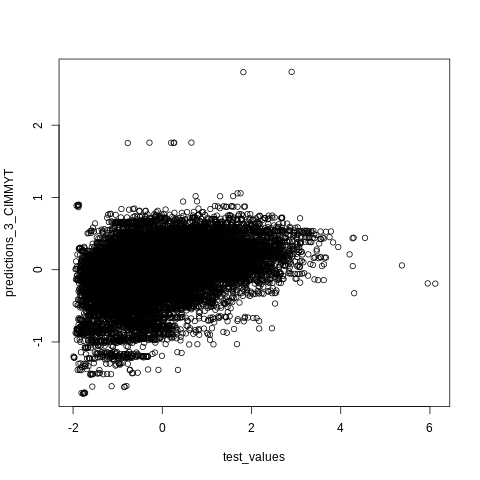

In [39]:
%%R
predictions_3_CIMMYT = fm3_CIMMYT$yHat[-train_random_sample]
test_values = y_sample$GRAIN_YIELD[-train_random_sample]
R2 = R2(predictions_3_CIMMYT, test_values)
RMSE = RMSE(predictions_3_CIMMYT, test_values)
MAE = MAE(predictions_3_CIMMYT, test_values)
model3_CIMMYT_scores = data.frame(R2, RMSE, MAE)
print(model3_CIMMYT_scores)
plot(test_values,predictions_3_CIMMYT)

In [0]:
%%R
# Fitting Model 3_GEE (Main Environment-Pedigree-Environmental Covariate Effects)
# (EAW)

W_gee_sample_div = W_gee_sample/sqrt(ncol(W_gee_sample))


In [0]:

ETA = list(PED=list(X=Z_star,model='BRR'),
           EC=list(X=W_gee_sample_div,model='BRR'))

fm3_gee = BGLR(y=y_train_na,ETA=ETA,saveAt='M3_',nIter=500,burnIn=200)


In [0]:
%%R
predictions_3_gee = fm3_gee$yHat[-train_random_sample]
test_values = y_sample$GRAIN_YIELD[-train_random_sample]
R2 = R2(predictions_3_gee, test_values)
RMSE = RMSE(predictions_3_gee, test_values)
MAE = MAE(predictions_3_gee, test_values)
model3_gee_scores = data.frame(R2, RMSE, MAE)
print(model3_gee_scores)
plot(test_values,predictions_3_gee)

## Model 5: Main Pedigree, Main Environment, and Interaction Effects

In [0]:
%%R
# Fitting Model 4 (Main Environment-Pedigree-Environmental Covariate Effects 
# with Pedigree-Environmental Covariate Interaction)
# (EAW-AxW) CIMMYT

# Results in vector of size 157.4 Gb, need sufficient RAM to hold

ZAZ = tcrossprod(Z_star)

W_matrix = as.matrix(W_CIMMYT_sample_div)

WW = tcrossprod(W_matrix)

K = ZAZ*WW
diag(K) = diag(K)+1/200 
K = K/mean(diag(K))
L2 = t(chol(K))

In [0]:
%%R
ETA = list(PED=list(X=Z_star,model='BRR'),
           EC=list(X=W_matrix,model='BRR'),
           AxW=list(X=L2,model='BRR'))

fm4_CIMMYT = BGLR(y=y_train_na,ETA=ETA, saveAt='M4_',nIter=500,burnIn=200)

        R2      RMSE       MAE
1 0.129605 0.9356254 0.7381873


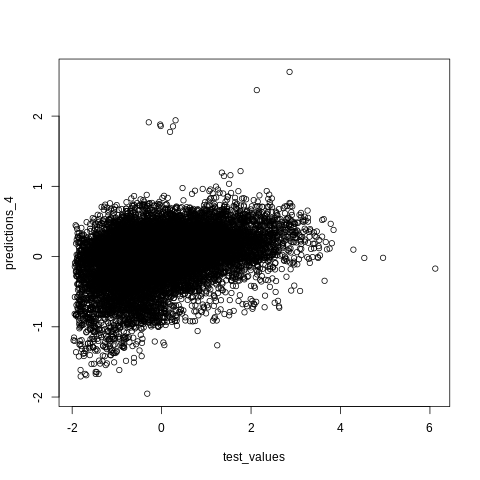

In [34]:
%%R
predictions_4 = fm4_CIMMYT$yHat[-train_random_sample]
test_values = y_sample$GRAIN_YIELD[-train_random_sample]
corr = cor(predictions_4, test_values)
R2 = R2(predictions_4, test_values)
RMSE = RMSE(predictions_4, test_values)
MAE = MAE(predictions_4, test_values)
model4_scores = data.frame(R2, corr, RMSE, MAE)
print(model4_scores)
plot(test_values,predictions_4)

In [0]:
%%R
remove(L2, W_matrix, K, WW)

In [36]:
%%R
# Garbage Collector to Clear up RAM
gc()

          [,1]   [,2]       [,3]    [,4]       [,5]    [,6]
[1,]   2564579  137.0    7524052   401.9    5109968   273.0
[2,] 764075096 5829.5 2279741304 17393.1 2849674259 21741.3


In [0]:
%%R
# Fitting Model 4 (Main Environment-Pedigree-Environmental Covariate Effects 
# with Pedigree-Environmental Covariate Interaction)
# (EAW-AxW) GEE

# ZAZ = tcrossprod(Z_star) # Already run above

W_matrix = as.matrix(W_gee_sample_div)

WW = tcrossprod(W_matrix)

K = ZAZ*WW
diag(K) = diag(K)+1/200 
K = K/mean(diag(K))
L2 = t(chol(K))

In [0]:
%%R
ETA = list(PED=list(X=Z_star,model='BRR'),
           EC=list(X=W_matrix,model='BRR'),
           AxW=list(X=L2,model='BRR'))

fm4_gee = BGLR(y=y_train_na,ETA=ETA, saveAt='M4_',nIter=500,burnIn=200)

R[write to console]: 


R[write to console]: #--------------------------------------------------------------------#

R[write to console]: #        _\\|//_                                                     #

R[write to console]: #       (` o-o ')      BGLR v1.0.8                                   #

R[write to console]: #------ooO-(_)-Ooo---------------------------------------------------#

R[write to console]: #                      Bayesian Generalized Linear Regression        #

R[write to console]: #                      Gustavo de los Campos, gdeloscampos@gmail.com #

R[write to console]: #    .oooO     Oooo.   Paulino Perez-Rodriguez, perpdgo@gmail.com    #

R[write to console]: #    (   )     (   )   November, 2018                                #

R[write to console]: #_____\ (_______) /_________________________________________________ #

R[write to console]: #      \_)     (_/                                                   #

R[write to console]: #                        

In [0]:
%%R
predictions_4 = fm4_gee$yHat[-train_random_sample]
test_values = y_sample$GRAIN_YIELD[-train_random_sample]
R2 = R2(predictions_4, test_values)
corr = cor(predictions_4, test_values)
RMSE = RMSE(predictions_4, test_values)
MAE = MAE(predictions_4, test_values)
model4_scores = data.frame(R2, corr, RMSE, MAE)
print(model4_scores)
plot(test_values,predictions_4)